# Building a content recommender for pizza

The goal of this project is to analyze the data available on Foursquare that describes pizza places in order to extract keywords, pizza images, and other data describing these restaurants, to build a content recommendation system. The data comes from both the Foursquare API. For this project, we will focus specifically on the greatest place in the world for pizza: Chicago, Illinois (and the greater metro area). The Foursquare API allows only 500 "premium" calls per day; premium calls being required to return review text ("tips"), and images. Returning more premium calls would require upgrading to a paid/commercial Foursquare API license, which is beyond the scope of this project (though we do end up making premium calls over a 3 day period to collect more data). The obvious features that we will use are the tips (analyzed by natural language processing for similarity measures and sentiment), ratings,  pricing tier, rating count, and additional restaurant categories. 

In [9]:
import pandas as pd
import numpy as np
import requests
import json
import folium
import re
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

import pizza_project_keys as keys

We construct a list of latitude/longitude pairs from counties in the greater Chicagoland area, so that we can query the Foursquare API more effectively (each request returns a limit of 50 results).

In [2]:
il_lat_long = pd.read_csv('IL-County-Data.csv')
il_lat_long.head()

,zip,primary_city,state,latitude,longitude,county,type,world_region,country,decommissioned,estimated_population,notes
0,60004,Arlington Heights,IL,42.09,-87.98,Cook,STANDARD,NaN,US,0,46798,NaN
1,60005,Arlington Heights,IL,42.09,-87.98,Cook,STANDARD,NaN,US,0,25773,NaN
2,60006,Arlington Heights,IL,42.09,-87.98,Cook,PO BOX,NaN,US,0,0,NaN
3,60007,Elk Grove Village,IL,42.00,-87.99,Cook,STANDARD,NaN,US,0,31802,NaN
4,60008,Rolling Meadows,IL,42.07,-88.02,Cook,STANDARD,NaN,US,0,20385,NaN


This CSV was downloaded from data.healthcare.gov. We can see that rows 0 and 1 have the same latitutde and longitude measures. We will filter out non-unique pairs, and throw out everything else since we just want to build a set of coordinates for querying via Foursquare. 

In [3]:
il_lat_long = il_lat_long[['latitude','longitude']].drop_duplicates().reset_index().iloc[:,1:3]
il_lat_long.head()

,latitude,longitude
0,42.09,-87.98
1,42.00,-87.99
2,42.07,-88.02
3,42.15,-88.12
4,42.03,-87.90


Next, we import our credentials to access the Foursquare API, and construct the URL to make our calls using the 'search' endpoint. We load our API keys from a .py file in the same directory to avoid publishing private data. 

In [5]:
GOOGLE_PRIVATE_KEY = keys.GOOGLE_PRIVATE_KEY
FOURSQUARE_PRIVATE_KEY = keys.FOURSQUARE_PRIVATE_KEY
FOURSQUARE_PUBLIC_KEY = keys.FOURSQUARE_PUBLIC_KEY
VERSION = '20200403'

In [6]:
category_dict = {'Pizza Place':'4bf58dd8d48988d1ca941735'} #this could easily to expanded to include more types of establishments that include pizza, including bars and italian restaurants.
catids = ",".join([value for value in category_dict.values()])
catids = catids[:-1] if catids[-1] == ',' else catids #this properly formats to a list of comma separated category IDs, trivial for a single category as we are using here.

Since we have a limited number of calls we can make to the API, we will test our methodology and verify that it returns the data we want, and that we can extract, transform, and load that data into a dataframe as desired.

In [7]:
radius = 10000
lat = il_lat_long.iloc[0,0]
long = il_lat_long.iloc[0,1]
LIMIT = 5
categoryId = catids
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    FOURSQUARE_PUBLIC_KEY, 
    FOURSQUARE_PRIVATE_KEY, 
    VERSION, 
    lat, 
    long, 
    radius, 
    LIMIT,
    categoryId)

In [8]:
results = requests.get(url).json()


In [9]:
pd.json_normalize(results['response']['venues'])

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,...,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,location.crossStreet
0,4c27c8cc97d00f47b3e93eea,Lou Malnati's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758279,False,1504 N Elmhurst Rd,42.094809,-87.936936,"[{'label': 'display', 'lat': 42.0948089242651,...",3597,...,IL,United States,"[1504 N Elmhurst Rd, Mount Prospect, IL 60056,...",738904,https://www.grubhub.com/restaurant/lou-malnati...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NaN
1,4b809605f964a520ef7e30e3,Lou Malnati's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758279,False,1050 E Higgins Rd,42.026847,-87.971286,"[{'label': 'display', 'lat': 42.02684705935034...",7066,...,IL,United States,"[1050 E Higgins Rd (at Joey Dr), Elk Grove Vil...",608444,https://www.grubhub.com/restaurant/lou-malnati...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at Joey Dr
2,4ac8e1a9f964a5200cbd20e3,Capri Deli,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758279,False,1625 N Rand Rd,42.140030,-88.022241,"[{'label': 'display', 'lat': 42.14003045227914...",6571,...,IL,United States,"[1625 N Rand Rd (at E Dundee Rd), Palatine, IL...",1728410,https://www.grubhub.com/restaurant/capri-deli-...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at E Dundee Rd
3,4aff86c1f964a520463922e3,Lou Malnati's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758279,False,85 S Buffalo Grove Rd,42.152782,-87.960457,"[{'label': 'display', 'lat': 42.15278219621459...",7172,...,IL,United States,"[85 S Buffalo Grove Rd (at Lake Cook Rd), Buff...",517712,https://www.grubhub.com/restaurant/lou-malnati...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at Lake Cook Rd
4,4bb6bc92941ad13a8ef41fe3,Joe's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758279,False,57 N Wolf Rd,42.140568,-87.915443,"[{'label': 'display', 'lat': 42.14056765288841...",7752,...,IL,United States,"[57 N Wolf Rd (at 6th St), Wheeling, IL 60090,...",NaN,NaN,NaN,NaN,NaN,NaN,at 6th St


We can see that our request worked as intended, returning 5 pizza places. Now we will use a function to loop over the lat/long list and request pizza places. We will probably return some duplicate data, but we can filter out non-distinct ids afterwards. Then, we can use our list of ids to make premium calls for only those pizza places. 

In [11]:
def get_pizza_places(lat_long_list):
    radius = 10000
    LIMIT = 50
    categoryId = catids
    places = pd.DataFrame()
    for i in range(len(lat_long_list)):
        lat, long = lat_long_list.iloc[i][0], lat_long_list.iloc[i][1]
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        FOURSQUARE_PUBLIC_KEY, 
        FOURSQUARE_PRIVATE_KEY, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT,
        categoryId
        )
        results = requests.get(url).json()
        places = places.append(pd.json_normalize(results['response']['venues']))
    return places
        

In [12]:
venues = get_pizza_places(il_lat_long)

In [13]:
venues.shape

(7437, 25)

In [14]:
venues.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,...,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,location.crossStreet,venuePage.id,location.neighborhood
0,4b4fac33f964a520341027e3,Armand's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,70 N Vail Ave,42.083450,-87.984170,"[{'label': 'display', 'lat': 42.0834500813442,...",806,...,"[70 N Vail Ave, Arlington Heights, IL 60005, U...",951254,https://www.grubhub.com/restaurant/armands-piz...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NaN,NaN,NaN
1,4b6b8c03f964a520210f2ce3,Mug's Pizza and Ribs,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,600 E Central Rd,42.066432,-87.908588,"[{'label': 'display', 'lat': 42.06643176032783...",6457,...,"[600 E Central Rd (at Wolf), Des Plaines, IL 6...",283566,https://www.grubhub.com/restaurant/mugs-pizza-...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at Wolf,NaN,NaN
2,4ccb619997d0224b94ff58b8,Tortorice's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,1735 E Central Rd,42.066109,-87.960913,"[{'label': 'display', 'lat': 42.06610862313999...",3091,...,"[1735 E Central Rd (at S Busse Rd), Arlington ...",283774,https://www.grubhub.com/restaurant/tortorices-...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at S Busse Rd,84921531,NaN
3,4ba54c3ff964a520bff738e3,Marisa's Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,4175 Dundee Rd,42.137553,-87.883513,"[{'label': 'display', 'lat': 42.1375532958455,...",9565,...,"[4175 Dundee Rd (at Sanders Rd), Northbrook, I...",NaN,NaN,NaN,NaN,NaN,NaN,at Sanders Rd,NaN,NaN
4,4bca7e48511f95210d06b0c7,Artistic Cuisine Inc.,"[{'id': '4bf58dd8d48988d107941735', 'name': 'A...",v-1586758280,False,16 S Bothwell St,42.110008,-88.045128,"[{'label': 'display', 'lat': 42.11000798616725...",5822,...,"[16 S Bothwell St (Palatine Rd.), Palatine, IL...",1023412,https://www.grubhub.com/restaurant/artistic-cu...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,Palatine Rd.,NaN,NaN


In [15]:
venues['identifier'] = venues['id']
venues.drop_duplicates(subset='identifier',inplace=True)
venues.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,...,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,location.crossStreet,venuePage.id,location.neighborhood,identifier
0,4b4fac33f964a520341027e3,Armand's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,70 N Vail Ave,42.083450,-87.984170,"[{'label': 'display', 'lat': 42.0834500813442,...",806,...,951254,https://www.grubhub.com/restaurant/armands-piz...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,NaN,NaN,NaN,4b4fac33f964a520341027e3
1,4b6b8c03f964a520210f2ce3,Mug's Pizza and Ribs,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,600 E Central Rd,42.066432,-87.908588,"[{'label': 'display', 'lat': 42.06643176032783...",6457,...,283566,https://www.grubhub.com/restaurant/mugs-pizza-...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at Wolf,NaN,NaN,4b6b8c03f964a520210f2ce3
2,4ccb619997d0224b94ff58b8,Tortorice's Pizzeria,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,1735 E Central Rd,42.066109,-87.960913,"[{'label': 'display', 'lat': 42.06610862313999...",3091,...,283774,https://www.grubhub.com/restaurant/tortorices-...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,at S Busse Rd,84921531,NaN,4ccb619997d0224b94ff58b8
3,4ba54c3ff964a520bff738e3,Marisa's Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1586758280,False,4175 Dundee Rd,42.137553,-87.883513,"[{'label': 'display', 'lat': 42.1375532958455,...",9565,...,NaN,NaN,NaN,NaN,NaN,NaN,at Sanders Rd,NaN,NaN,4ba54c3ff964a520bff738e3
4,4bca7e48511f95210d06b0c7,Artistic Cuisine Inc.,"[{'id': '4bf58dd8d48988d107941735', 'name': 'A...",v-1586758280,False,16 S Bothwell St,42.110008,-88.045128,"[{'label': 'display', 'lat': 42.11000798616725...",5822,...,1023412,https://www.grubhub.com/restaurant/artistic-cu...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,Palatine Rd.,NaN,NaN,4bca7e48511f95210d06b0c7


In [16]:
venues.shape

(1080, 26)

We ended up dropping over 6000 duplicate venues, leaving about 1000 unique venues. Let's take a look at the counts for each name in our dataframe, since there are many pizza chains which have multiple locations.

In [273]:
venues['name'].value_counts()

Domino's Pizza              60
Rosati's Pizza              52
Pizza Hut                   48
Giordano's                  43
Little Caesars Pizza        41
                            ..
North Branch                 1
Craft Pizza                  1
Hearth & Crust               1
WISE GUYS PIZZERIA           1
Vito & Nicks II Pizzaria     1
Name: name, Length: 594, dtype: int64

In [286]:
ids = list(venues['id'])

Now we have a list of ids to iterate through, using each id to make a "detail" endpoint call to Foursquare. However, each detail call is considered a premium call, and our verified personal account is limited to 500 premium calls per day. Thus, we will complete the 1085 calls over a 3 day period. To accomplish this, our ID list is subset to lists of size 500.

In [296]:
venues.to_csv(path_or_buf = "venues.csv",columns=['id','name'])

In [25]:
ids = pd.read_csv('venues.csv')['id']

In [205]:
ids_day1 = ids[0:500]
ids_day2 = ids[500:1000]
ids_day3 = ids[1000:]

In [203]:
def get_venue_details(venue_ids):
    venue_details = dict()
    for id in venue_ids:
        url = f'https://api.foursquare.com/v2/venues/{id}?&client_id={FOURSQUARE_PUBLIC_KEY}&client_secret={FOURSQUARE_PRIVATE_KEY}&v={VERSION}'
        temp = requests.get(url).json()
        venue_details[id] = temp['response']
    return venue_details
        

In [8]:
dict1=get_venue_details(ids_day1)

In [12]:
with open('day1','w') as file:
    file.write(json.dumps(dict1))

In [19]:
dict2 = get_venue_details(ids_day2)

In [22]:
with open('day2','w') as file:
    file.write(json.dumps(dict2))

In [206]:
dict3 = get_venue_details(ids_day3)

with open('day3','w') as file:
    file.write(json.dumps(dict3))
    

In [209]:
print(" Day 1 details retrieved: "+str(len(day1))+'\n',
     "Day 2 details retrieved: "+str(len(day2))+'\n',
     "Day 3 details retrieved: "+str(len(day3)))

 Day 1 details retrieved: 500
 Day 2 details retrieved: 500
 Day 3 details retrieved: 85


Note that in this context, we have chosen to fetch and store the raw json, rather than convert to a dataframe and append new data as it is retrieved. This is done to avoid the awkward situation in which we change our minds and wish to use data that was not inserted into our df, but need to wait until our premium call quota is reset.

We will now keep the relevant aspects of the venue details and create a dataframe object that we can more easily analyze and manipulate. One major downside of using Foursquare is that we only get 1 tip per venue unless we fully upgrade to a paid enterprise account, which is clearly beyond the scope of this project. Though it is quite easy to scrape for tip data by using the returned URLs and the BeautifulSoup package, this would violate the "Foursquare API Platform and Data Use Policy", so we will proceed with the understanding that 

Clearly we want to keep the name of the restaurant, the address (for cross-matching with results from Google API) stored as venue['location'], the categories (we know all venues are "Pizza Places", but secondary classifications could be interesting, stats, url, price, likes, rating, ratingSignals, 

In [11]:
column_names = ['Name','Address','Latitude','Longitude','Additional Categories','Tip Count','Pricing Tier','Likes','Average Rating','Rating Count','Reasons Summary',
                             'Tip 1 Text','Tip 1 Agree Count','Tip 1 Disagree Count','Tip 2 Text','Tip 2 Agree Count','Tip 2 Disagree Count']

In [12]:
def venue_dict_to_df(venue_dict):
    venues_df = pd.DataFrame(columns=column_names)
    for venue in venue_dict.values():
#         print(venue['venue']['id'])
        cats = venue['venue']['categories']
        tips = venue['venue']['tips']['groups'][0]['items']
        tip_count = len(tips)
        venues_df = venues_df.append(pd.DataFrame(data=[[
            venue['venue']['name'],
            venue['venue']['location'].get('address',None),
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            [cat['name'] for cat in cats if cat['name'] != "Pizza Place"],
            venue['venue']['stats']['tipCount'],
            venue['venue']['price']['tier'] if venue['venue'].get('price') else None,
            venue['venue']['likes']['count'],
            venue['venue'].get('rating',None),
            venue['venue'].get('ratingSignals',None),
            venue['venue']['reasons']['items'][0]['summary'] if venue['venue']['reasons']['count'] > 0 else None,
            tips[0]['text'] if tip_count > 0 else None,
            tips[0]['agreeCount'] if tip_count > 0 else None,
            tips[0]['disagreeCount'] if tip_count > 0 else None,
            tips[1]['text'] if tip_count > 1 else None,
            tips[1]['agreeCount'] if tip_count > 1 else None,
            tips[1]['disagreeCount'] if tip_count > 1 else None,
            
        ]],columns=column_names))
    return venues_df

In [13]:
with open("day1.json") as data:
    day1 = json.load(data)

with open("day2.json") as data:
    day2 = json.load(data)
    
with open("day3.json") as data:
    day3 = json.load(data)

In [14]:
venues_df = pd.concat([venue_dict_to_df(day1),venue_dict_to_df(day2),venue_dict_to_df(day3)])

In [15]:
venues_df

,Name,Address,Latitude,Longitude,Additional Categories,Tip Count,Pricing Tier,Likes,Average Rating,Rating Count,Reasons Summary,Tip 1 Text,Tip 1 Agree Count,Tip 1 Disagree Count,Tip 2 Text,Tip 2 Agree Count,Tip 2 Disagree Count
0,Armand's Pizzeria,70 N Vail Ave,42.083450,-87.984170,[],15,2,24,7.3,48,None,Not good service,1,0,The patio is awesome! Great location and good ...,1,0
0,Mug's Pizza and Ribs,600 E Central Rd,42.066432,-87.908588,[],9,1,12,7.9,18,None,I tried to give them another try but my co wor...,0,0,Pizza. It's good.,0,0
0,Artistic Cuisine Inc.,16 S Bothwell St,42.110008,-88.045128,"[Argentinian Restaurant, Italian Restaurant]",19,2,33,8.6,46,Lots of people like this place,our new special menu seasonal,1,0,our new special menu,1,0
0,Moretti's Ristorante And Pizzeria,1799 S Busse Rd,42.034134,-87.959849,"[Bar, American Restaurant]",13,2,46,7.5,71,Lots of people like this place,Try the fettichini alfredo (did I spell that r...,1,0,Great food. Service is very hit and miss.,1,0
0,Tortorice's Pizzeria,1735 E Central Rd,42.066109,-87.960913,[],11,1,22,8.5,34,None,"Best Pizza in town, they been around forever!",1,0,You have to get the picasso pizza,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Giordano's,815 W Van Buren St,41.876388,-87.647932,[Italian Restaurant],42,2,141,8.1,207,Lots of people like this place,Appetizers are here...,14,0,"best deep dish pizza in Chicago, love that tom...",0,0
0,Margarita's Pizzeria II,346 E 75th St,41.758489,-87.616446,[],4,1,13,6.9,17,None,Bro im right by you,1,0,The tostadas are pretty tasty. I like their pi...,0,0
0,Beggar's Pizza,3277 W 115th St,41.683924,-87.701023,[],0,1,0,None,None,None,None,None,None,None,None,None
0,Beggars Pizza,12700 Kedzie Ave,41.661801,-87.700468,[],0,1,3,None,None,None,None,None,None,None,None,None


### Now that we have acquired data, let's begin exploring it via summary statistics and visualizations.

In [388]:
%matplotlib inline

In [389]:
map_chicagoland = folium.Map(
    location=[venues_df['Latitude'].mean(),venues_df['Longitude'].mean()], 
    zoom_start=10
)

# add markers to map
for lat, lng, name, address in zip(venues_df['Latitude'], venues_df['Longitude'], venues_df['Name'], venues_df['Address']):
    label = '{}; {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#2186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicagoland)  
    
map_chicagoland

Although we won't be using location as a feature for making our reccomendations (we attempted to eliminate this affect by limiting ourselves to pizza places in the greater Chicagoland area), it is still interesting to view a layout of our data on a map.

Some of the names of chains are not uniform: we have both "Beggars Pizza" and "Beggar's Pizza" as well as "beggers pizza". Let's use regex matching to find and replace those values with a uniform name. 

In [16]:
def clean_names(name):
    if re.search('beg|Beg',name):
        return "Beggar's Pizza"
    else:
        return name

In [17]:
venues_df['Name'] = venues_df['Name'].apply(clean_names)

locations = venues_df['Name'].value_counts()

In [18]:
categories = pd.Series([category for sublist in venues_df['Additional Categories'] for category in sublist]).value_counts()

Italian Restaurant      209
Restaurant              100
American Restaurant      47
Bar                      20
Sports Bar               14
Fast Food Restaurant     13
Sandwich Place           13
Pub                       7
Salad Place               6
Wine Bar                  6
dtype: int64

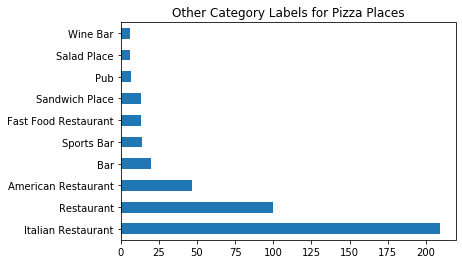

In [19]:
display(categories[0:10],categories[0:10].plot(kind="barh",title = "Other Category Labels for Pizza Places"))

We can see that the most common additional category to "Pizza Place" is "Italian Restaurant", which is quite unsurprising. Different styles of pizza are generally served at Italian Restaurants than at other pizza places, so this feature may prove to be important. 

One issue we must consider and handle is the presence of chains and franchises. While some pizza places are one-offs, a number of them have multiple locations. Let's take a look at the counts for names of pizza places in our data.

Domino's Pizza            60
Rosati's Pizza            52
Pizza Hut                 48
Giordano's                43
Lou Malnati's Pizzeria    41
Little Caesars Pizza      41
Papa John's Pizza         35
Beggar's Pizza            22
MOD Pizza                 16
Nancy's Pizza             10
Name: Name, dtype: int64

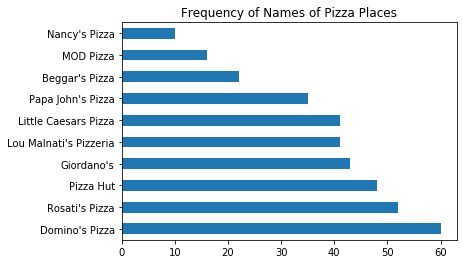

In [20]:
display(venues_df['Name'].value_counts()[0:10],venues_df['Name'].value_counts()[0:10].plot(kind="barh", title = "Frequency of Names of Pizza Places"))

Clearly we have quite a few chains, and if we make the (possibly flawed) assumption that one Pizza Hut is approximately the same (in terms of the _product quality_) as any other Pizza Hut, then we can consolidate all Pizza Huts together. Of course, service is much more likely to vary from location to location, but our interest is in building a pizza recommender, rather than a food experience/restaurant recommender (in which service quality would play a much more important role). 

Since we will be aggregating our data, let's take care of some other cleaning and consider the "Reasons Summary" column; at a glance there appear to be many missing values, let's confirm and drop if that is the case.

In [21]:
venues_df['Reasons Summary'].value_counts()

Lots of people like this place    192
Name: Reasons Summary, dtype: int64

Looks like the only reason summary is that "lots of people like this place". That summary seems to be based on the "Likes" feature, which we will be keeping, so it's probable that "Likes" is sufficient. We will proceed with dropping "Reasons Summary" as we aggregate.

In [23]:
venues_df['Tips'] = venues_df.apply(
    lambda row: [{row['Tip 1 Text']:[row['Tip 1 Agree Count'],row['Tip 1 Disagree Count']]},
                {row['Tip 2 Text']:[row['Tip 2 Agree Count'],row['Tip 2 Disagree Count']]}],
    axis=1)



In [24]:
venues_df.drop(['Reasons Summary', 'Tip 1 Text', 'Tip 1 Agree Count',
       'Tip 1 Disagree Count', 'Tip 2 Text', 'Tip 2 Agree Count',
       'Tip 2 Disagree Count',],axis=1,inplace=True)

In [25]:
venues_df.head()

,Name,Address,Latitude,Longitude,Additional Categories,Tip Count,Pricing Tier,Likes,Average Rating,Rating Count,Tips
0,Armand's Pizzeria,70 N Vail Ave,42.083450,-87.984170,[],15,2,24,7.3,48,"[{'Not good service': [1, 0]}, {'The patio is ..."
0,Mug's Pizza and Ribs,600 E Central Rd,42.066432,-87.908588,[],9,1,12,7.9,18,[{'I tried to give them another try but my co ...
0,Artistic Cuisine Inc.,16 S Bothwell St,42.110008,-88.045128,"[Argentinian Restaurant, Italian Restaurant]",19,2,33,8.6,46,"[{'our new special menu seasonal': [1, 0]}, {'..."
0,Moretti's Ristorante And Pizzeria,1799 S Busse Rd,42.034134,-87.959849,"[Bar, American Restaurant]",13,2,46,7.5,71,[{'Try the fettichini alfredo (did I spell tha...
0,Tortorice's Pizzeria,1735 E Central Rd,42.066109,-87.960913,[],11,1,22,8.5,34,"[{'Best Pizza in town, they been around foreve..."


In [26]:
venues_df.dtypes

Name                      object
Address                   object
Latitude                 float64
Longitude                float64
Additional Categories     object
Tip Count                 object
Pricing Tier              object
Likes                     object
Average Rating            object
Rating Count              object
Tips                      object
dtype: object

We can see that some of our numeric columns are not recognized as such, so we will convert them to float.

In [27]:
convert_list = ['Tip Count','Pricing Tier','Likes','Average Rating','Rating Count']
venues_df[convert_list] = venues_df[convert_list].apply(pd.to_numeric, axis=1)

In [28]:
aggregation_functions = {'Additional Categories': 'sum', 'Tip Count': 'sum', 'Pricing Tier': 'mean','Likes':'sum', 'Average Rating':'mean','Rating Count':'sum','Tips': lambda x: list(x)}

In [29]:
venues_df = venues_df.groupby(venues_df['Name']).aggregate(aggregation_functions)

Before we remove any rows of data, let's add a column that includes the number of locations, based on the df.value_counts object called locations that we created earlier

In [30]:
venues_df['Locations'] = locations
venues_df.loc["Giordano's"]

Additional Categories    [Restaurant, Restaurant, Restaurant, Restauran...
Tip Count                                                             1545
Pricing Tier                                                       1.32558
Likes                                                                 5481
Average Rating                                                      7.8907
Rating Count                                                          7605
Tips                     [[{'The portion is really so big for a person ...
Locations                                                               43
Name: Giordano's, dtype: object

We can see that Giordano's, for example, has 43 categories. Let's reduce "additional categories" so that it only contains unique additional categories for each name.

In [31]:
venues_df['Additional Categories'] = venues_df['Additional Categories'].apply(lambda x: {item for item in x})

Now we must consider the question of what to do with data which have many missing values for important features, such as pizza places with no ratings or no tips. Let's remove these.

In [37]:
venues_df = venues_df[~((venues_df['Tip Count'] == 0.0) | (venues_df['Rating Count'] == 0.0))]

In [38]:
venues_df.to_csv('cleaned_pizza_data.csv')

### Part 2: Data Analysis

Now that we have cleaned and prepared our data, we can begin building our recommender system.

In [39]:
venues_df = pd.read_csv("cleaned_pizza_data.csv")

In [40]:
venues_df.head()

,Unnamed: 0,Name,Additional Categories,Tip Count,Pricing Tier,Likes,Average Rating,Rating Count,Tips,Locations
0,1,Abruzzo's,"{'Bar', 'Italian Restaurant'}",5.0,4.0,9.0,8.20,15.0,[[{'Great neighborhood Italian restaurant with...,1
1,4,Al's Pizza,set(),11.0,1.0,18.0,7.90,32.0,"[[{'Best thin crust pizza in the burbs!': [1, ...",1
2,7,Alex's Washington Gardens,{'Italian Restaurant'},8.0,2.0,15.0,7.90,24.0,[[{'The best restaurant in Highwood. Amazing h...,1
3,9,Als Pizza Chicago,{'Restaurant'},5.0,1.0,6.0,7.00,14.0,"[[{""Excellent thin crust. Soooooo happy with A...",1
4,10,Amato's Pizza & More,set(),10.0,1.5,19.0,7.25,37.0,"[[{'If you ever go to Chicago, this pizza shop...",2


In [41]:
venues_df.shape

(425, 10)

Since some venues have multiple locations, we of course have more data available for those venues. We have aggregated rating count